In [1]:
##############################################################
# use google drive, only for Colab
##############################################################
'''from google.colab import drive
drive.mount('/content/drive/')

save_path = '/content/drive/My Drive/RecolorizationEncDecIResNet/output/'''

"from google.colab import drive\ndrive.mount('/content/drive/')\n\nsave_path = '/content/drive/My Drive/RecolorizationEncDecIResNet/output/"

In [2]:
# copy code from google drive and unzip
'''!cp /content/drive/My\ Drive/RecolorizationEncDecIResNet.zip /content/
!unzip RecolorizationEncDecIResNet.zip -d ./'''

'!cp /content/drive/My\\ Drive/RecolorizationEncDecIResNet.zip /content/\n!unzip RecolorizationEncDecIResNet.zip -d ./'

In [3]:
##############################################################
# import packages
##############################################################
import numpy as np
import itertools
import shutil
import random
import os
import matplotlib.pyplot as plt

# tensorflow/keras
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger,ReduceLROnPlateau
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, InputLayer, BatchNormalization
#from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D
#from tensorflow.keras.layers import RepeatVector, Permute, Input, Reshape, concatenate
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras import backend
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.client import device_lib
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from skimage.io import imsave
from skimage import img_as_ubyte
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from PIL import Image, ImageOps


In [4]:
##############################################################
# set variables / global parameters
##############################################################
# number of training/validation/test examples
num_train_images = 1 #40000 # 9000
num_valid_images = 1 #5148 # 1815
num_test_images = 1

# learning parameter
var_learning_rate = 0.0001
var_batch_size = 1
var_num_show_image = 1
var_epochs=1
var_steps_per_epoch=int(num_train_images / var_batch_size * var_num_show_image)
var_steps_validation = int(num_valid_images / var_batch_size)
var_verbose=1

# select data read mode
# 0: import/read data to/from array (use for <10GB), 1: import/read data to/from drive (use for >10GB)
read_mode = 1

# select running mode (train, proceed training or inference)
# 0: train model, 1: proceed with training (use saved model), 2: inference on test data (use saved model)
run_mode = 0
# use only for run_mode = 1 or 2
if(run_mode==1 or run_mode==2):
  model_to_proceed = 'modelEncDecIResNet001.h5'
  var_initial_epoch = 1

# select running environment
working_path = os.getcwd()
working_path+='/RecolorizationEncDecIResNet'
print(working_path)

# datasets
# 0: unsplash photos, 1: movie posters
var_data_set = 1
if(var_data_set == 0):
  train_dataset = 'unsplash/train/'
  valid_dataset = 'unsplash/valid/'
  test_dataset = 'unsplash/test/'
elif(var_data_set == 1):
  train_dataset = 'postersLargeClearedResizedPadded/train/'
  valid_dataset = 'postersLargeClearedResizedPadded/valid/'
  test_dataset = 'postersLargeClearedResizedPadded/test/'
elif(var_data_set == 2):
  train_dataset = 'postersLargeMixedResizedPadded/train/'
  valid_dataset = 'postersLargeMixedResizedPadded/valid/'
  test_dataset = 'postersLargeMixedResizedPadded/test/'

C:\Users\d91482\Desktop\code\finalVersion\content/RecolorizationEncDecIResNet


In [5]:
##############################################################
# set/test cpu/gpu settings
# activate memory growth on gpu
##############################################################
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Avaible GPUs: ', len(physical_devices))
if(len(physical_devices) > 0):
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
device_lib.list_local_devices()


Avaible GPUs:  0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6285759322486631837,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6995561419278732335
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16317065246848437849
 physical_device_desc: "device: XLA_GPU device"]

In [6]:
##############################################################
# change to working directory
# prepare paths for train / valid / test images
# import utils / custom functions
##############################################################
if os.getcwd() != working_path:
  os.chdir(working_path)
current_path = os.getcwd()

# set paths to subfolders
train_path = current_path + '/input/' + train_dataset
valid_path = current_path + '/input/' + valid_dataset
test_path = current_path + '/input/' + test_dataset
output_path = current_path + '/output/'
logs_path = current_path + '/logs/'

# import custom utils with auxiliary functions
import sys
sys.path.append(current_path + '/code/')
import utils
from utils import plotImages, inception_embedding, batch_generator, evaluate_input, import_images, image_resize_with_padding, metric_psnr
import modelEncDecIResNet 
from modelEncDecIResNet import get_modelEncDecIResNet, LossAndErrorPrintingCallback, CustomTensorBoard

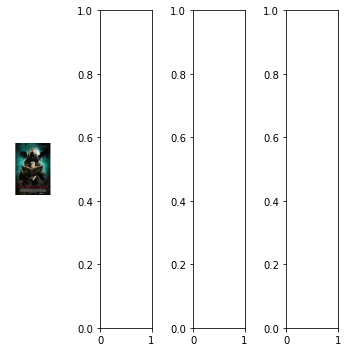

In [7]:
##############################################################
# import data and plot 10 examples
# optional, when reading data from drive
##############################################################
Xtrain_rgb = []
Xvalid_rgb = []
Xtest_rgb = []

# import data as images or from .npy-files 
if(read_mode==0):
  # import validation data
  Xbuffer = import_images(valid_path + 'images/', num_valid_images)
  Xvalid_rgb = np.array(Xbuffer[0:num_valid_images], dtype=float) / 255
  #Xvalid_rgb = np.load(valid_path + 'validArray.npy')
  print('validation data imported')
  
  # import training data
  Xbuffer = import_images(train_path + 'images/', num_train_images)
  Xtrain_rgb = np.array(Xbuffer[0:num_train_images], dtype=float) / 255
  #Xtrain_rgb = np.load(train_path + 'trainArray.npy')
  print('training data imported')

  # import test data
  Xbuffer = import_images(test_path + 'images/', num_test_images)
  Xtest_rgb = np.array(Xbuffer[0:num_test_images], dtype=float) / 255

# import data from drive (only for illustration)
elif(read_mode==1):
  Xbuffer = import_images(valid_path + 'images/', 4)
  Xvalid_rgb = np.array(Xbuffer, dtype=float) / 255 
  Xbuffer = import_images(train_path + 'images/', 4)
  Xtrain_rgb = np.array(Xbuffer, dtype=float) / 255
  Xbuffer = import_images(test_path + 'images/', 4)
  Xtest_rgb = np.array(Xbuffer, dtype=float) / 255

# plot 4 examples
plotImages(Xtrain_rgb, 4)
#plotImages(Xvalid_rgb, 4)
#plotImages(Xtest_rgb, 4)

In [8]:
##############################################################
# load weights of the external model (InceptionResNetV2)
##############################################################
modelInceptionResNet = InceptionResNetV2(weights=None, include_top=True)
modelInceptionResNet.load_weights(working_path + '/extmodel/' + 'modelInceptionResNet.h5')
#modelInceptionResNet.summary()

# !!! download pretrained InceptionResNetV2 model:
''' load and save InceptionResNet-model (first load)
modelInceptionResNet = InceptionResNetV2(weights='imagenet', include_top=True)
modelInceptionResNet.summary()
save_model = modelInceptionResNet.to_json()
with open(working_path + '/extmodel/' + 'modelInceptionResNet.json', "w") as json_file:
  json_file.write(save_model)
modelInceptionResNet.save_weights(working_path + '/extmodel/' + 'modelInceptionResNet.h5')
'''

# define and compile the full model
modelEncDecIResNet = get_modelEncDecIResNet()
modelEncDecIResNet.compile(optimizer=Adam(learning_rate=var_learning_rate),loss='mse',metrics=['mean_absolute_error',metric_psnr])
#modelEncDecIResNet.summary()

In [9]:
##############################################################
# generate batches and execute training
##############################################################

#DataGenerator = ImageDataGenerator(shear_range=0.1, zoom_range=0.1, rotation_range=10, horizontal_flip=True)
DataGenerator = ImageDataGenerator(rescale=1./255)
if(read_mode==0):
  print('read data from array')
  train_batches = DataGenerator.flow(Xtrain_rgb, batch_size=var_batch_size)
  valid_batches = DataGenerator.flow(Xvalid_rgb, batch_size=var_batch_size)
  test_batches = DataGenerator.flow(Xtest_rgb, batch_size=var_batch_size, shuffle=False)
elif(read_mode==1):
  print('read data from drive')
  train_batches = DataGenerator.flow_from_directory(directory=train_path, batch_size=var_batch_size)
  valid_batches = DataGenerator.flow_from_directory(directory=valid_path, batch_size=var_batch_size)
  test_batches = DataGenerator.flow_from_directory(directory=test_path, batch_size=var_batch_size, shuffle=False)


# checkpoints: save model weights after each epoch, save logs from tensorboard, save loss and metrics
checkpoint = [ModelCheckpoint(output_path + 'saved_model/' + 'modelEncDecIResNet{epoch:03d}.h5', 
                            monitor='loss', verbose=1, save_best_only=False, mode='auto', save_freq='epoch'),
              #TensorBoard(logs_path, update_freq='batch', write_graph=False, write_images=False),
              CustomTensorBoard(logs_path, update_freq='batch', write_graph=False, write_images=False),
              LossAndErrorPrintingCallback(),
              #CSVLogger(output_path + 'log.csv', append = True, separator=';'),
              ReduceLROnPlateau(monitor='loss', factor=0.5, verbose=1, patience=10, min_lr=0.000001),
              ]

# run model for training
if run_mode == 0:
  print('start training')
  history_callback = modelEncDecIResNet.fit(batch_generator(var_batch_size, train_batches, modelInceptionResNet), 
                         epochs=var_epochs, 
                         steps_per_epoch=var_steps_per_epoch, 
                         validation_data = batch_generator(var_batch_size,valid_batches,modelInceptionResNet),
                         validation_steps=var_steps_validation, 
                         verbose=var_verbose,
                         callbacks=[checkpoint]
                         )
# proceed with training
elif run_mode == 1:
  print('load saved model, proceed with training')
  modelEncDecIResNet.load_weights(output_path + 'saved_model/' + model_to_proceed)
  history_callback = modelEncDecIResNet.fit(batch_generator(var_batch_size, train_batches, modelInceptionResNet), 
                         epochs=var_epochs, 
                         steps_per_epoch=var_steps_per_epoch, 
                         validation_data = batch_generator(var_batch_size,valid_batches,modelInceptionResNet),
                         validation_steps=var_steps_validation, 
                         verbose=var_verbose, 
                         callbacks=[checkpoint],
                         initial_epoch = var_initial_epoch
                         )
# model inference
else:
  print('load saved model, prepaired for inference')
  modelEncDecIResNet.load_weights(output_path + 'saved_model/' + model_to_proceed)



##############################################################
# save model and model weights, manually
##############################################################
'''
if run_mode == 0 or run_mode == 1:
  print('save model weigths')
  save_model = modelEncDecIResNet.to_json()
  with open(output_path + '/saved_model/' + 'modelEncDecIResNet.json', "w") as json_file:
    json_file.write(save_model)
  modelEncDecIResNet.save_weights(output_path + 'saved_model/' + 'modelEncDecIResNet.h5')
'''
##############################################################
# compute loss on the validation set, manually
##############################################################
'''[Xvalid_lab,embed], Yvalid_lab = evaluate_input(Xvalid_rgb, modelInceptionResNet)
print(modelEncDecIResNet.evaluate([Xvalid_lab,embed], Yvalid_lab, batch_size=var_batch_size))
'''
print('finished')

read data from drive
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
start training
 For training batch 0, loss is 0.0097158.
1/1 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0672 - metric_psnr: 20.1252 For validation batch 0, loss is 0.0147897.

Epoch 00001: saving model to C:\Users\d91482\Desktop\code\finalVersion\content\RecolorizationEncDecIResNet/output/saved_model\modelEncDecIResNet001.h5
The average loss for epoch 0 is 0.0097158 and mean absolute error is 0.0671765.
1/1 [==============================] - 1s 1s/step - loss: 0.0097 - mean_absolute_error: 0.0672 - metric_psnr: 20.1252 - val_loss: 0.0148 - val_mean_absolute_error: 0.1140 - val_metric_psnr: 18.3004 - lr: 1.0000e-04
finished


In [10]:
##############################################################
# colorize images from test set
#############################################################
Xtest_rgb = []
Xbuffer = import_images(test_path + 'images/', num_test_images)
Xtest_rgb = np.array(Xbuffer, dtype=float) / 255

[Xtest_lab,embed], Ytest_lab = evaluate_input(Xtest_rgb, modelInceptionResNet)
Xpred_lab = modelEncDecIResNet.predict([Xtest_lab, embed])
Xpred_lab =  Xpred_lab * 128

for i in range(len(Xpred_lab)):
    bufferImage = np.zeros((256, 256, 3))
    bufferImage[:,:,0] = Xtest_lab[i][:,:,0]
    bufferImage[:,:,1:] = Xpred_lab[i]
    imsave(output_path+'results/'+str(i)+".png", img_as_ubyte(lab2rgb(bufferImage)))

print('test images plotted')

test images plotted


In [11]:
##############################################################
# initialize tensorboard session
##############################################################
'''!tensorboard dev upload --logdir ./logs \
    --name "experiment: movie posters" \
    --description "training results " \
    --one_shot'''

'!tensorboard dev upload --logdir ./logs     --name "experiment: movie posters"     --description "training results "     --one_shot'

In [12]:
# delete tensorboard session
'''!tensorboard dev delete --experiment_id #'''

'!tensorboard dev delete --experiment_id #'

In [13]:
##############################################################
# only for Colab
##############################################################
'''!zip -r RecolorizationEncDecIResNetResult.zip '/content/RecolorizationEncDecIResNet/'
!cp RecolorizationEncDecIResNetResult.zip /content/drive/My\ Drive/'''

"!zip -r RecolorizationEncDecIResNetResult.zip '/content/RecolorizationEncDecIResNet/'\n!cp RecolorizationEncDecIResNetResult.zip /content/drive/My\\ Drive/"